In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import json
import os
import random

import numpy as np
import torch
import scipy.io

from experiment import lesion
from experiment import mRNN
from experiment import michaels_load
from experiment import stim
from experiment import utils

#CUDA = torch.device(0)
CUDA = None

# XXX These are not Windows-compatible paths. Too lazy to tokenize and join.
PATH_M1_NO_COADAPT = "models/gaussian20.1.75_outputsIdxs50.100_gaussianExp16.2.175_enActTanh_cpnActTanh/301cdce9-4c0c-489d-accf-58673219fb84"
PATH_M1_COADAPT = "models/gaussian20.1.75_outputsIdxs0.50_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/0a2a06be-56e8-4692-8f18-64a021ab8933"

PATH_AIP_NO_COADAPT = "models/gaussian20.1.75_outputsIdxs200.250_gaussianExp16.2.175_enActTanh_cpnActTanh/16130497-5e97-4396-aed7-540c5863cdd7"
PATH_AIP_COADAPT = "models/gaussian20.1.75_outputsIdxs200.250_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/d5cb145f-9ea9-402c-981a-4780b47d9f79"

PATH_CON_NO_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh/c7583779-4622-40a6-a259-59f2e8c0cfd9"
PATH_CON_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh_coadapt/d6304fab-9cfd-4bff-ba29-32872a75a3d0"

PATH_PRERECOV_COADAPT = "models/gaussian20.1.75_connectionsIdxs[(1, 2, 0, 1), (0, 1, 1, 2), (2, 3, 0, 1), (0, 1, 2, 3)]_gaussianExp16.2.175_enActTanh_cpnActTanh_recovPre_coadapt/f692f909-5396-42a7-ab40-6f438cd4ab13"

In [49]:
EPOCH_SCALAR = 100.0

def recover_pct_loss_eq(tl1, pr1, tl2, pr2):
    m = (pr2 - pr1) / (tl2 - tl1)
    c = pr1 - m * tl1
    
    lesion_loss = (-c) / m
    healthy_loss = (1 - c) / m
    
    print(lesion_loss, healthy_loss)
    
    return m, c

def loss_eq_from_hist(task_loss_recs, pct_recov_recs):
    tl1 = None
    tl2 = None
    id1 = None
    id2 = None
    for idx, r in enumerate(task_loss_recs):
        if tl1 is None:
            tl1 = r
            id1 = idx
        elif r != tl1:
            tl2 = r
            id2 = idx
            break
            
    pr1 = pct_recov_recs[id1]
    pr2 = pct_recov_recs[id2]
            
    return recover_pct_loss_eq(tl1, pr1, tl2, pr2)

def graph_results(root_path, fig, axs_loss, axs_sep):
    log_path = os.path.join(root_path, "log")
    
    recs = json.load(open(log_path, "r"))
    
    pct_recov = []
    task_loss = []
    sep = []
    for r in recs:
        try:
            recov_c = float(r['pct_recov'])
            sep_c = float(r['class_separation'])
            tl_c = float(r['task_loss'])
        except ValueError:
            continue
            
        pct_recov.append(recov_c)
        task_loss.append(tl_c)
        sep.append(sep_c)
        
    m, c = loss_eq_from_hist(task_loss, pct_recov) 
    pct_recov_val = []
    for r in recs:
        try:
            loss_val = float(r['task_val_loss'])
        except ValueError:
            continue
        
        prcv = c + m * loss_val
        pct_recov_val.append(prcv)

        
    epoch_count = len(recs)
        
    axs_loss.plot([eidx / EPOCH_SCALAR for eidx in range(len(pct_recov))], pct_recov, color="tab:blue")
    axs_loss.plot([eidx / EPOCH_SCALAR for eidx in range(len(pct_recov_val))], pct_recov_val, color="tab:orange")
    axs_sep.plot([eidx / EPOCH_SCALAR for eidx in range(len(sep))], sep)
    axs_sep.plot([0, epoch_count / EPOCH_SCALAR], [0.0, 0.0], color='r', linestyle='-', linewidth=2)

0.18230835483870964 -0.001530354838709153
0.021025333333333344 0.0023586666666665277


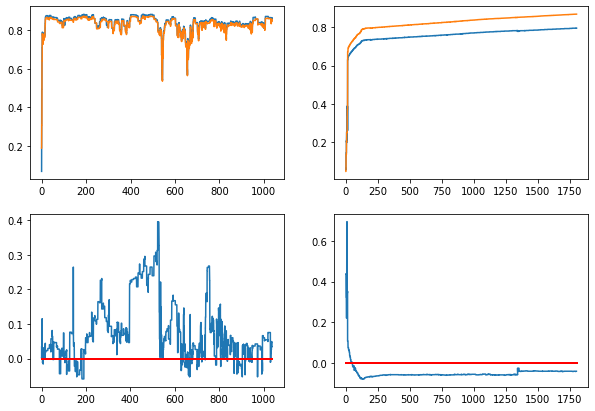

In [50]:
fig,axs = plt.subplots(2, 2, figsize=(10, 7))

graph_results(PATH_M1_NO_COADAPT, fig, axs[0, 0], axs[1, 0])
graph_results(PATH_M1_COADAPT, fig, axs[0, 1], axs[1, 1])

plt.show()

# Conclusion: recovery possible in both cases
# Conclusion: class separation improves after initially being low

0.004451999999999934 0.0004519999999998409
0.00414525000000001 -0.0006047499999999656


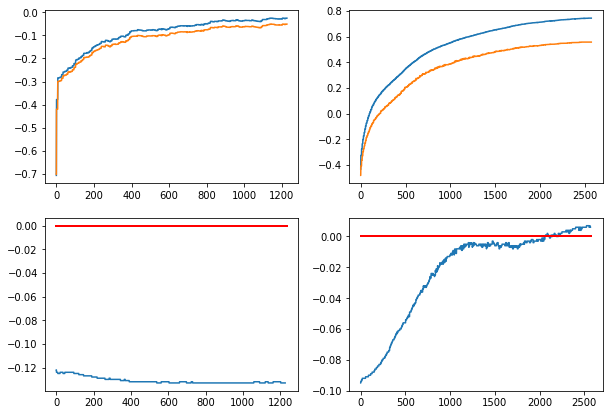

In [51]:
fig,axs = plt.subplots(2,2, figsize=(10, 7))

graph_results(PATH_AIP_NO_COADAPT, fig, axs[0, 0], axs[1, 0])
graph_results(PATH_AIP_COADAPT, fig, axs[0, 1], axs[1, 1])

plt.show()

# Conclusion: loss of encoding machinery means we don't have information enough to condition stimulus
# Conclusion: with co-adaptation, the two work together to solve the problem
# Non-conclusion: recovery alone would/wouldn't solve the problem

0.02071420833333333 0.0007558749999999841
0.02071314545454546 0.0006949636363636155


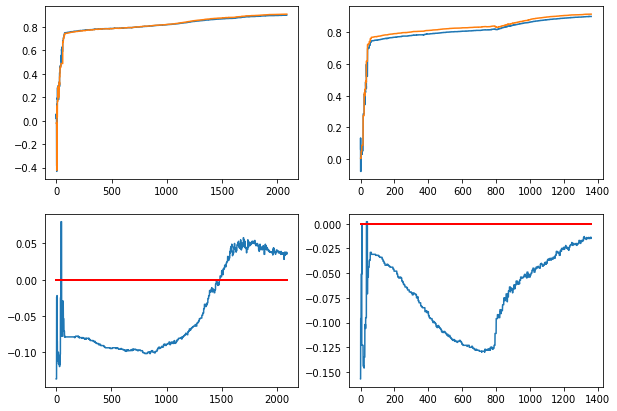

In [52]:
fig,axs = plt.subplots(2,2, figsize=(10, 7))

graph_results(PATH_CON_NO_COADAPT, fig, axs[0, 0], axs[1, 0])
graph_results(PATH_CON_COADAPT, fig, axs[0, 1], axs[1, 1])

plt.show()

# Conclusion: recovery is steady after an initial rapid improvement
# Conclusion: initially the structure of the problem (i.e. hold) is learned, followed by object differentiation

0.018800333333333346 0.001133666666666664


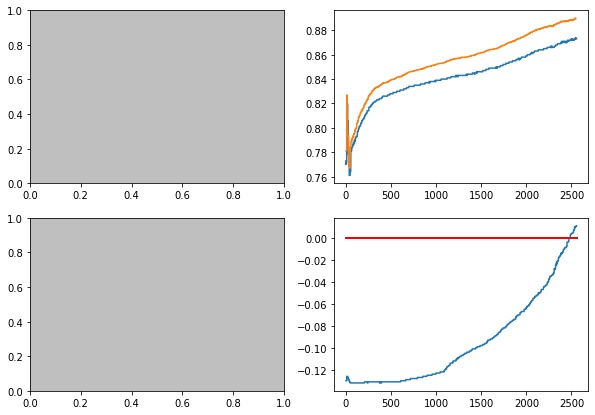

In [53]:
fig,axs = plt.subplots(2,2, figsize=(10, 7))

graph_results(PATH_PRERECOV_COADAPT, fig, axs[0, 1], axs[1, 1])

axs[0, 0].patch.set_facecolor('0.75')
axs[1, 0].patch.set_facecolor('0.75')

plt.show()

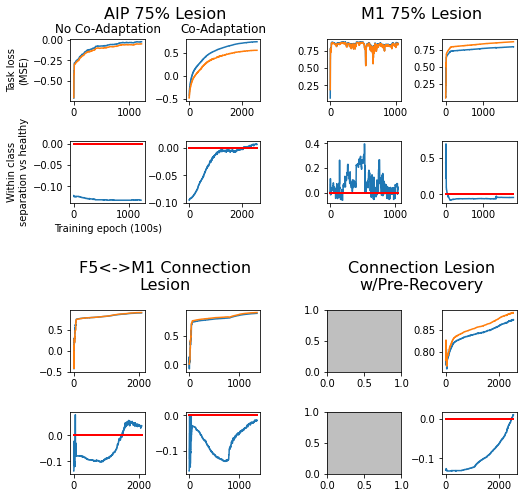

In [41]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8, 8))
outer = gridspec.GridSpec(2, 2, wspace=0.35, hspace=0.65)

def graph_category(fig, subplot, title, path1=None, path2=None):
    
    title_sp = plt.Subplot(fig, subplot)
    title_sp.set_title(title, fontsize=16, pad=20)
    title_sp.axis('off')
        
    fig.add_subplot(title_sp)
    
    inner = gridspec.GridSpecFromSubplotSpec(2, 2,
            subplot_spec=subplot, wspace=0.55, hspace=0.65)
    
    axs_loss1 = plt.Subplot(fig, inner[0, 0])
    axs_sep1 = plt.Subplot(fig, inner[1, 0])
    if path1 is not None:    
        graph_results(path1, fig, axs_loss1, axs_sep1)
    fig.add_subplot(axs_loss1)
    fig.add_subplot(axs_sep1)
        
    axs_loss2 = plt.Subplot(fig, inner[0, 1])
    axs_sep2 = plt.Subplot(fig, inner[1, 1])    
    if path2 is not None:
        graph_results(path2, fig, axs_loss2, axs_sep2)
    fig.add_subplot(axs_loss2)
    fig.add_subplot(axs_sep2)
    
    return axs_loss1, axs_sep1,axs_loss2, axs_sep2


axs_loss1, axs_sep1, axs_loss2, _ = graph_category(fig, outer[0], "AIP 75% Lesion",
                                                   PATH_AIP_NO_COADAPT, PATH_AIP_COADAPT)
axs_loss1.set_title("No Co-Adaptation", fontsize=12)
axs_loss1.set_ylabel("Task loss\n(MSE)", fontsize=10)
axs_sep1.set_ylabel("Within class\nseparation vs healthy", fontsize=10)
axs_sep1.set_xlabel("Training epoch (100s)", fontsize=10)
axs_loss2.set_title("Co-Adaptation", fontsize=12)

graph_category(fig, outer[1], "M1 75% Lesion", PATH_M1_NO_COADAPT, PATH_M1_COADAPT)

graph_category(fig, outer[2], "F5<->M1 Connection\nLesion", PATH_CON_NO_COADAPT, PATH_CON_COADAPT)


axs_loss1, axs_sep1, _, _ = graph_category(fig, outer[3], "Connection Lesion\nw/Pre-Recovery",
                                           None, PATH_PRERECOV_COADAPT)
axs_loss1.patch.set_facecolor('0.75')
axs_sep1.patch.set_facecolor('0.75')

plt.savefig('paper/figs/training_results.png', format='png', dpi=300, bbox_inches='tight')
plt.show()